In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib as mpl #
import matplotlib.pyplot as plt
%matplotlib inline


import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

C:\Users\PC-Wendy\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



In [2]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_tweets_data(tweet):
    #print('clean_tweets_data called')
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+",
        flags=re.UNICODE,
    )
    url_pattern = re.compile(r"\S+\/\S+", re.DOTALL)
    mentions_pattern = re.compile(r"@\S+", re.DOTALL)
    hashtag_pattern = re.compile(r"#\S+", re.DOTALL)
    bitly_pattern = re.compile(r"bit.ly\S+", re.DOTALL)
    pic_pattern = re.compile(r"pic.twitter\S+", re.DOTALL)
    retweet_pattern = re.compile(r"twitter.com\S+", re.DOTALL)


    text_without_emoji = emoji_pattern.sub(r"", tweet)
    text_without_url = url_pattern.sub(r"", text_without_emoji)

    text_without_mention = mentions_pattern.sub(r"",text_without_url)
    text_without_hashtag = hashtag_pattern.sub(r"",text_without_mention)
    text_without_bitly = bitly_pattern.sub(r"",text_without_hashtag)
    text_without_pic = pic_pattern.sub(r"",text_without_bitly)
    final_text = retweet_pattern.sub(r"",text_without_pic)

    #print('returning cleaned_tweets with length ' + str(len(cleaned_tweets)))
    return final_text 



def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

 
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
 


In [174]:
stops = stopwords.words('spanish')

In [171]:
datafile = 'data/la_razon_partidos.csv'
nombre="LA RAZON"
pie="La Razon"
titulo=nombre+"\nTÓPICOS Y PERSONAJES"


In [172]:
tweets = pd.read_csv(datafile, encoding='utf-8-sig')

print("Number of tweets: ",len(tweets['tweet']))
#tweets.head(5)
round0 = lambda x: clean_tweets_data(x)
data_clean = pd.DataFrame(tweets.tweet.apply(round0))
 
round1 = lambda x: clean_text_round1(x)
data_clean = pd.DataFrame(data_clean.tweet.apply(round1))

round2 = lambda x: clean_text_round2(x)
data_clean = pd.DataFrame(data_clean.tweet.apply(round2))
#data_clean
text = " ".join(rev for rev in data_clean.tweet)

Number of tweets:  143


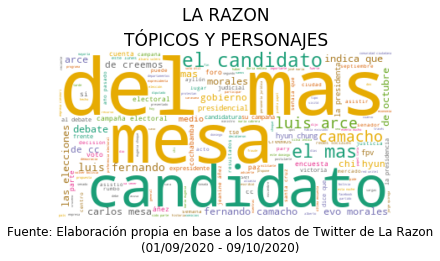

In [175]:
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stops, background_color="white", 
                      colormap="Dark2",max_font_size=150, random_state=42).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()
#plt.xticks(fontsize = 2)


#plt.text(1,1,'text')
plt.figtext(0.5, 0.1, "Fuente: Elaboración propia en base a los datos de Twitter de "+
           pie+"\n(01/09/2020 - 09/10/2020)", ha="center", fontsize=12)

#plt.xlabel("Fuente: Elaboración propia en base a los datos de Twitter de "+
#           pie+"\n(01/09/2020 - 09/10/2020)", fontsize = 12, labelpad = 10)
plt.title(titulo, color='k',fontsize = 17)

plt.savefig("img_nube_"+nombre+".png")

linea de tiempo

In [306]:
datafile = 'data/la_razon_partidos.csv'
tweets = pd.read_csv(datafile, encoding='utf-8-sig')
tweets.head()

,data-item-id,username,tweet,date,partido
0,1314042118357291009,@LaRazon_Bolivia,#AnimalPolítico \nViene la elección más polar...,2020-10-07,CC
1,1313854330873749504,@LaRazon_Bolivia,#PiedraPapelYTinta #EleccionesBolivia \nMerca...,2020-10-07,CC
2,1313543998515154948,@LaRazon_Bolivia,#Nacional #EleccionesBolivia \nEl candidato d...,2020-10-06,CC
3,1313323532231811072,@LaRazon_Bolivia,#Nacional #PiedraPapelYTinta \nLos voceros de...,2020-10-05,CC
4,1313499644756926464,@LaRazon_Bolivia,#PiedraPapelYTinta #EleccionesBolivia\nNovill...,2020-10-06,CC


In [307]:
menciones=tweets['partido'].value_counts()
menciones

MAS        86
CC         26
CREEMOS    16
FPV        12
Libre21     2
PAN-BOL     1
Name: partido, dtype: int64

In [308]:
tweets.groupby(['date', 'partido']).size()

date        partido
2020-09-01  CC         1
            MAS        1
2020-09-02  CREEMOS    2
            MAS        2
2020-09-03  MAS        4
                      ..
2020-10-08  CC         1
            FPV        1
            MAS        1
2020-10-10  CC         1
            MAS        3
Length: 70, dtype: int64

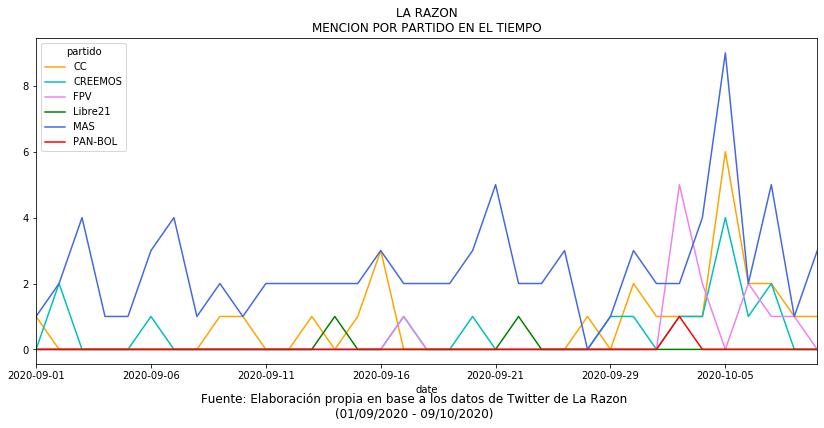

In [309]:
colors = ['orange','c','violet', 'g','royalblue', 'r']
tweets.groupby(['date', 'partido']).size().unstack().fillna(0).plot(kind='line',figsize=(14,6),colors = colors,
                                                                    title='LA RAZON\nMENCION POR PARTIDO EN EL TIEMPO')
plt.figtext(0.5, 0.001, "Fuente: Elaboración propia en base a los datos de Twitter de La Razon"+
           "\n(01/09/2020 - 09/10/2020)", ha="center", fontsize=12)
plt.savefig("LA RAZON MENCIONES TIEMPO.png")

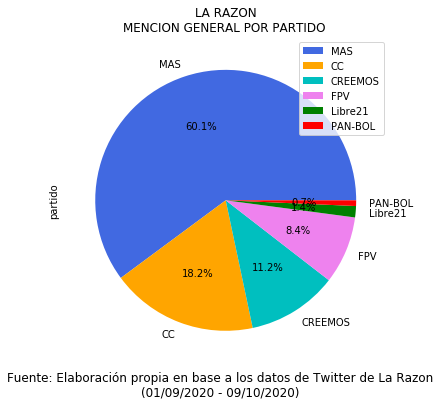

In [310]:
colors = ['royalblue','orange','c','violet', 'g', 'r']
#labels = [ i for i in tweets["partido"].unique()]
tweets['partido'].value_counts().plot(kind='pie', figsize=(6,6),autopct='%1.1f%%', legend = True, 
                                      colors = colors, #labels=labels,
                                      title='LA RAZON\nMENCION GENERAL POR PARTIDO ')
plt.figtext(0.5, 0.05, "Fuente: Elaboración propia en base a los datos de Twitter de La Razon"+
           "\n(01/09/2020 - 09/10/2020)", ha="center", fontsize=12)
plt.savefig("LA RAZON MENCIONES PARTIDO.png")

In [311]:
datafile = 'data/el_deber_partidos.csv'
tweets = pd.read_csv(datafile, encoding='utf-8-sig')
tweets.head()

,data-item-id,username,tweet,date,partido
0,1313468485427752961,@grupoeldeber,En Creemos apuntan a Carlos Mesa como el res...,2020-10-06,CC
1,1311447628618530817,@grupoeldeber,Luis Arce y Carlos Mesa empezaron a desprend...,2020-09-30,CC
2,1309946062740828162,@grupoeldeber,Te puede interesar:\n\n- Socio de red ATB an...,2020-09-26,CC
3,1309999917130297346,@grupoeldeber,Camacho decidió quedarse en Santa Cruz y Mes...,2020-09-26,CC
4,1307450635990728704,@grupoeldeber,- Murillo desmiente renuncia y dice que sólo...,2020-09-19,CC


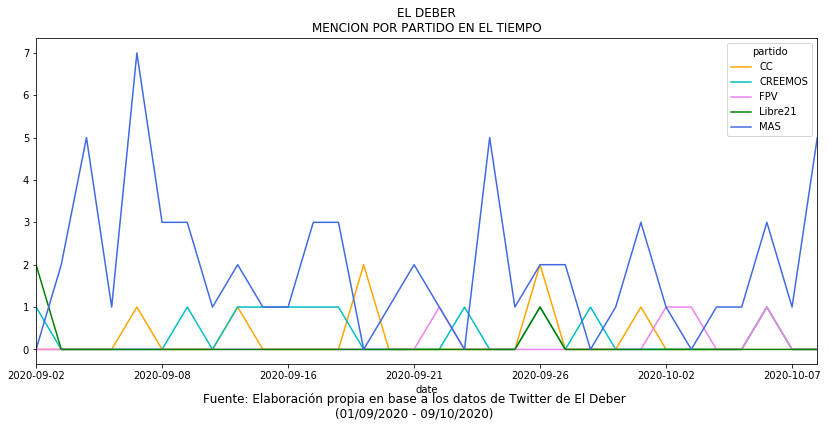

In [312]:
colors = ['orange','c','violet', 'g','royalblue', 'r']
tweets.groupby(['date', 'partido']).size().unstack().fillna(0).plot(kind='line',figsize=(14,6),colors = colors,
                                                                    title='EL DEBER\nMENCION POR PARTIDO EN EL TIEMPO')
plt.figtext(0.5, 0.001, "Fuente: Elaboración propia en base a los datos de Twitter de El Deber"+
           "\n(01/09/2020 - 09/10/2020)", ha="center", fontsize=12)
plt.savefig("EL DEBER MENCIONES TIEMPO.png")

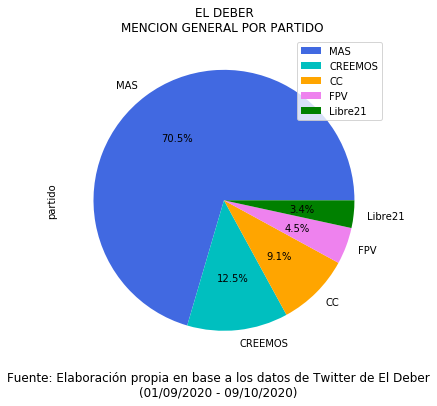

In [314]:
colors = ['royalblue','c','orange','violet', 'g', 'r']
#labels = [ i for i in tweets["partido"].unique()]
tweets['partido'].value_counts().plot(kind='pie', figsize=(6,6),autopct='%1.1f%%', legend = True, 
                                      colors = colors, #labels=labels,
                                      title='EL DEBER\nMENCION GENERAL POR PARTIDO ')
plt.figtext(0.5, 0.05, "Fuente: Elaboración propia en base a los datos de Twitter de El Deber"+
           "\n(01/09/2020 - 09/10/2020)", ha="center", fontsize=12)
plt.savefig("EL DEBER MENCIONES PARTIDO.png")